**Name:** Weng Yuqian

**EID:** 55972965

# CS5489 - Tutorial 6
## Dimensionality Reduction and Face Recognition

In this tutorial you will use linear and non-linear dimensionality reduction on face images, and then train a classifier for face recognition.

First we need to initialize Python.  Run the below cell.

In [2]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)
rbow = plt.get_cmap('rainbow')

## 1. Loading Data and Pre-processing
We first need to load the images.  Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [3]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show an example:

(64, 64)


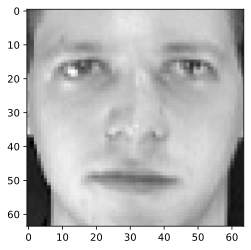

In [4]:
print(img[0].shape)
plt.imshow(img[0], cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

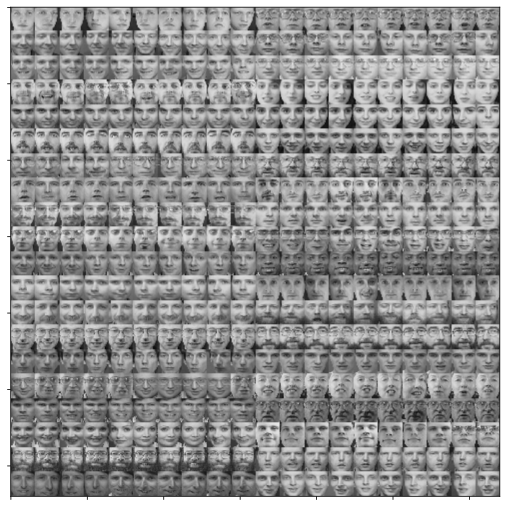

In [5]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. The class labels are in vector `Y`. Now we split the data into training and testing sets.

In [6]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


# 2. Linear Dimensionality Reduction - PCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use PCA to reduce the dimension first and then use the PCA weights as the representation for each image.  Run PCA oon the data using 9 principal components.

In [7]:
### INSERT YOUR CODE HERE

In [8]:
pca = decomposition.PCA(n_components=9)
W = pca.fit_transform(trainX)  
Wt  = pca.transform(testX)      

The below function will plot the basis vectors of PCA. Run the next 2 cells to view the PCs.

In [9]:
def plot_basis(model, imgsize):
    cname = model.__class__.__name__
    if  cname == 'LDA':
        KK = model.n_components
        comps = model.coef_
        mn    = None
    elif cname == 'PCA':
        KK = model.n_components_
        comps = model.components_
        mn    = model.mean_
    elif cname == 'NMF':
        KK = model.n_components_
        comps = model.components_
        mn    = None
    K = KK
    if mn is not None:
        K += 1        
    nr = ceil(K/5.0)
    sind = 1

    #vmin = comps.flatten().min()
    #vmax = comps.flatten().max()
    
    # plot the mean
    pcfig = plt.figure(figsize=(8,nr*2))
    if mn is not None:
        plt.subplot(nr,5,sind)
        plt.imshow(mn.reshape(imgsize), interpolation='nearest')
        plt.title("mean")
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])    
        sind += 1
    # plot the components
    for j in range(0,KK):
        plt.subplot(nr,5,sind)
        v = comps[j,:]            
        I = v.reshape(imgsize)
        plt.imshow(I, interpolation='nearest')
        plt.gray()
        plt.title("basis " + str(j+1))
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        sind += 1

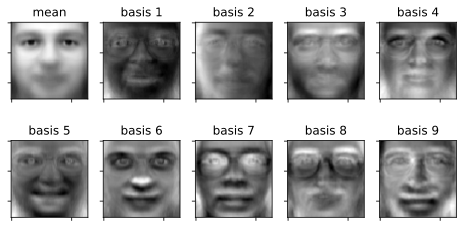

In [10]:
# run the function
plot_basis(pca, imgsize)

_What do the basis images look like? Do some basis images correspond to particular facial features?_
- **These basis images look like ghost. Some basis images do correspond to particular facial features. For example, basis image 3 and 5 are correspond on eyebrow, and basis image 7 and 8 and 9 are focus on glasses.**

### Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated PCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  _You do not need to do cross-validation for the number of components._  Calculate the average training and testing accuracies.  Remember to transform the test data into the PCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

In [11]:
### INSERT YOUR CODE HERE

In [12]:
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
logreg.fit(W, trainY)
predictY  = logreg.predict(Wt)
acc  = metrics.accuracy_score(testY,predictY)
print("test accuracy :", acc)

E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


test accuracy : 0.7


## Finding the best number of components
Now try a range of number of components for PCA to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plot of PCA dimension vs. test accuracy.

In [13]:
### INSERT YOUR CODE HERE

In [14]:
ns = linspace(1,100,20,dtype=int)
Accuracies = []
for n in ns:
    pca = decomposition.PCA(n_components=n)
    Wtrain = pca.fit_transform(trainX)  
    Wtest  = pca.transform(testX)  
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, verbose=1, n_jobs=-1)
    logreg.fit(Wtrain, trainY)
    predictY = logreg.predict(Wtest)
    testacc = metrics.accuracy_score(testY, predictY)
    Accuracies.append(testacc)

E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.3s finished
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.2s finished
E:

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.9s finished
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.9s finished
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[P

Text(0, 0.5, 'accuracy')

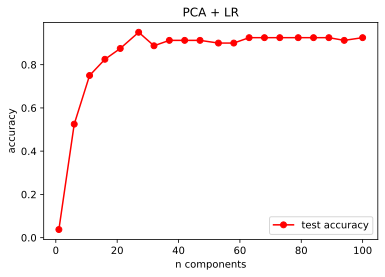

In [15]:
plt.plot(ns, Accuracies, 'ro-', label='test accuracy')
plt.title("PCA + LR")
plt.legend(loc=0)
plt.xlabel('n components')
plt.ylabel('accuracy')

_What is the best number of components?  View the basis images to see what they look like_
- **The best number of componets is 27**

In [16]:
### INSERT YOUR CODE HERE

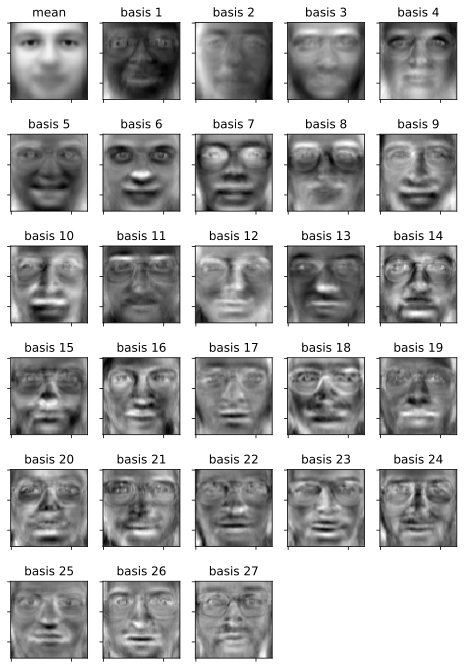

In [17]:
pca = decomposition.PCA(n_components=27)
pca.fit_transform(trainX)
plot_basis(pca, imgsize)

# 3. Linear Dimensionality Reduction - NMF
Now we will repeat the experiment using non-negative matrix factorization instead of PCA.  Perform NMF with 9 components and visualize the basis images.

In [18]:
### INSERT YOUR CODE HERE

In [19]:
nmf = decomposition.NMF(n_components=9)
WtrainNMF = nmf.fit_transform(trainX) 
WtestNMF  = nmf.transform(testX)

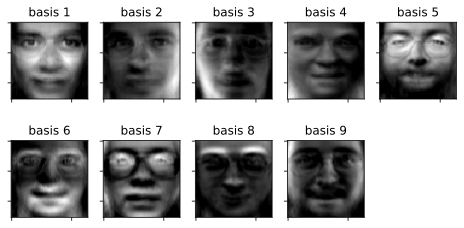

In [20]:
plot_basis(nmf, imgsize)

_What do the basis images look like?  What is the main difference with the PCA basis images?_
- **These images look more like human face. NMF only considers positive features.**

### Finding the best number of components
Now find the number of components that gives the best test accuracy.  Use the same type of classifier that you used in the previous experiment.  Use cross-validation to select the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components.

In [21]:
### INSERT YOUR CODE HERE

In [22]:
ns = linspace(1,100,20,dtype=int)
NMFAccuracies = []
for n in ns:
    pca = decomposition.NMF(n_components=n)
    Wtrain = pca.fit_transform(trainX)  
    Wtest  = pca.transform(testX)  
    logreg.fit(Wtrain, trainY)
    predictY = logreg.predict(Wtest)
    testacc = metrics.accuracy_score(testY, predictY)
    NMFAccuracies.append(testacc)

E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.6s finished
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.5s finished
E:

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.9s finished
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   30.6s finished
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[P

_Which number of components give the best test result? How does the accuracy compare to the best PCA result?  Why is NMF or PCA better?_
- **The number of components give the best test result is about 50. PCA provides better performance.**

In [23]:
### INSERT YOUR CODE HERE

Text(0, 0.5, 'accuracy')

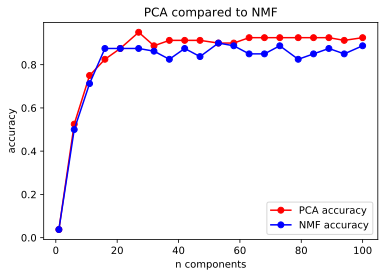

In [24]:
plt.plot(ns, Accuracies, 'ro-', label='PCA accuracy')
plt.plot(ns, NMFAccuracies, 'bo-', label='NMF accuracy')
plt.title("PCA compared to NMF")
plt.legend(loc=0)
plt.xlabel('n components')
plt.ylabel('accuracy')

# Non-Linear Dimensionality Reduction - KPCA
Now we will use KPCA to perform non-linear dimensionality reduction on the data  before training the classifier.  Run KPCA on the data using 10 principal components.  Use the RBF kernel with gamma=0.001.

In [25]:
### INSERT YOUR CODE HERE ###

In [26]:
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
WtrainKPCA = kpca.fit_transform(trainX)
WtestKPCA  = kpca.transform(testX)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [27]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

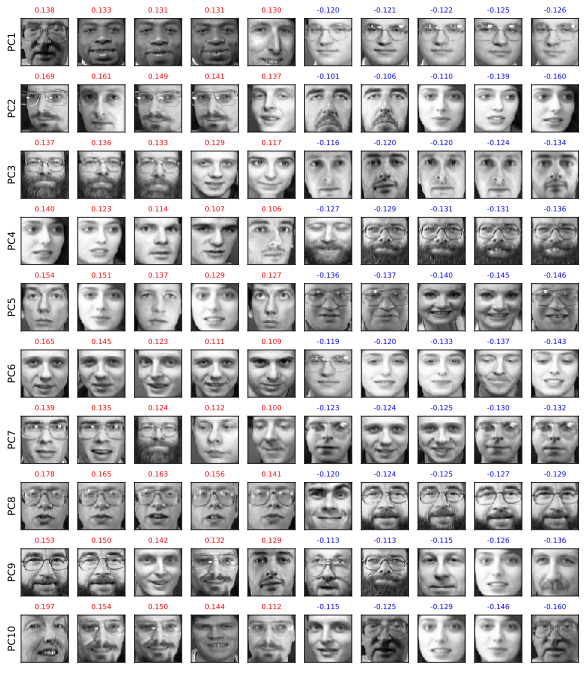

In [28]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- **PC8 prefers faces with glasses**

### Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

In [38]:
### INSERT YOUR CODE HERE
RBFAccuracies = []
ns = linspace(1,100,20,dtype=int)
for n in ns:
    for g in logspace(-3,3,5):
        kpca = decomposition.KernelPCA(n_components=n, kernel='rbf', gamma=g)
        Wtrain = kpca.fit_transform(trainX)  
        Wtest  = kpca.transform(testX)  
        logreg.fit(Wtrain, trainY)
        predictY = logreg.predict(Wtest)
        testacc = metrics.accuracy_score(testY, predictY)
        RBFAccuracies.append(testacc)

E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.8s finished
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   41.4s finished
E:

LinAlgError: unrecoverable internal error.

In [ ]:
polyAccuracies = []
ns = linspace(1,100,20,dtype=int)
for n in ns:
    for g in logspace(-3,3,5):
        kpca = decomposition.KernelPCA(n_components=n, kernel='rbf', gamma=g)
        Wtrain = kpca.fit_transform(trainX)  
        Wtest  = kpca.transform(testX)  
        logreg.fit(Wtrain, trainY)
        predictY = logreg.predict(Wtest)
        testacc = metrics.accuracy_score(testY, predictY)
        polyAccuracies.append(testacc)

In [ ]:
plt.plot(ns, RBFAccuracies, 'ro-', label='PCA accuracy')
plt.plot(ns, polyAccuracies, 'bo-', label='NMF accuracy')
plt.title("RBF compared to poly")
plt.legend(loc=0)
plt.xlabel('n components')
plt.ylabel('accuracy')

_What is the best kernel and number of components?  View the prototypes for each compenent to see what they look like_
- **INSERT YOUR ANSWER HERE**

*Which dimensionality reduction method performs the best for classification? Why?*
- **INSERT YOUR ANSWER HERE**
